## Importing Libraries

We use Pandas (heavy lifting), matplotlib (graphs), SKLearn (Cosine Similarity) and SciPy (CSR matrix).

In [1]:
import warnings  # To hide FutureWarnings from Pandas regarding use of concat
warnings.simplefilter(action='ignore', category=FutureWarning)
from statistics import mean
from random import choices
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

## Dataset

This data was downloaded from…

### Data Cleaning

The code in this section has been commented as it only needs to be run once to clean the data. The cleaned data has been exported to CSV files and will be used in the rest of the notebook. The code is left here for reference.

#### Importing Raw Data

In [2]:
# raw_data = pd.read_csv('UserBehavior.csv',names=['userID','itemID','category','behavior','datetime'])
# print("Raw Data:")
# raw_data.info()

# Raw Data:
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 100150807 entries, 0 to 100150806
# Data columns (total 5 columns):
#  #   Column    Dtype 
# ---  ------    ----- 
#  0   userID    int64 
#  1   itemID    int64 
#  2   category  int64 
#  3   behavior  object
#  4   datetime  int64 
# dtypes: int64(4), object(1)
# memory usage: 3.7+ GB

We have 100,150,807 interactions in the dataset. The dataset has 5 columns, which are:
- userID: the user who performed the interaction
- itemID: the item which was interacted with
- category: the category of the item
- behavior: the type of interaction (buy, cart, favourite, page view)
- datetime: the time when the interaction happened (in seconds)

#### Removing Duplicates and Empty Values

In [3]:
# clean = raw_data.drop_duplicates().dropna()
# print(f"We removed {raw_data.shape[0] - clean.shape[0]} items which were duplicates or had empty values.")

# We removed 49 items which were duplicates or had empty values.

#### Converting Dates

In [4]:
# clean['datetime'] = pd.to_datetime(clean['datetime'], unit='s')
# clean['date'] = clean['datetime'].dt.date
# clean['time'] = clean['datetime'].dt.time
# 
# print("Example of Data with datetime (original) and separate date/time columns:")
# clean.head()

# Example of Data with datetime (original) and separate date/time columns:
# | index | userID | itemID | category | behavior | datetime | date | time |
# | 0 | 1 | 2268318 | 2520377 | pv | 2017-11-24 17:21:10 | 2017-11-24 | 17:21:10 |
# | 1 | 1 | 2333346 | 2520771 | pv | 2017-11-24 22:15:33 | 2017-11-24 | 22:15:33 |
# | 2 | 1 | 2576651 | 149192  | pv | 2017-11-25 01:21:25 | 2017-11-25 | 01:21:25 |
# | 3 | 1 | 3830808 | 4181361 | pv | 2017-11-25 07:04:53 | 2017-11-25 | 07:04:53 |
# | 4 | 1 | 4365585 | 2520377 | pv | 2017-11-25 07:49:06 | 2017-11-25 | 07:49:06 |

Note how the date and time are now in separate columns.

#### Trimming Dates

In [5]:
# clean = clean.drop(columns=['datetime'])
# clean['date'] = pd.to_datetime(clean['date'])
# clean1 = clean[(clean['date'] >= '2017-11-25') & (clean['date'] <= '2017-12-03')]
# print(f"We removed {clean.shape[0] - clean1.shape[0]:,} items which had dates outside the expected range.")
# print(f"Our clean dataset now has {clean1.shape[0]:,} items.")

# We removed 1,236,274 items which had dates outside the expected range.
# Our clean dataset now has 98,914,484 items.

### Exporting Cleaned Data

Given the large size of the dataset, we will be exporting the cleaned data to CSV files with 1M, 10M and 100M rows. This will allow us to work with smaller datasets while developing and testing our models.

In [6]:
# clean1.to_csv('clean_100M.csv', index=False)  # It is really 98.9M, but we will call it 100M for simplicity
# clean1.head(1000000).to_csv('clean_1M.csv', index=False)
# clean1.head(10000000).to_csv('clean_10M.csv', index=False)

## Exploratory Data Analysis

### Overall Statistics

In [7]:
# # TODO: Define which dataset to use
# current_dataset = 'clean_100M.csv'

# data = pd.read_csv(current_dataset)
# size_of_dataset = data.shape[0]

# buy_actions = data[data['behavior']=='buy']
# pageview_actions = data[data['behavior']=='pv']
# addtocart_actions = data[data['behavior']=='cart']
# markfavourite_actions = data[data['behavior']=='fav']

# print(f"Number of unique users: {data['userID'].nunique():,}")
# print(f"Number of unique items: {data['itemID'].nunique():,}")
# print(f"Number of unique categories: {data['category'].nunique():,}")
# print(f"Number of page views: {len(pageview_actions):,} ({len(pageview_actions)/size_of_dataset:.2%})")
# print(f"Number of add to carts: {len(addtocart_actions):,} ({len(addtocart_actions)/size_of_dataset:.2%})")
# print(f"Number of mark favourites: {len(markfavourite_actions):,} ({len(markfavourite_actions)/size_of_dataset:.2%})")
# print(f"Number of buys: {len(buy_actions):,} ({len(buy_actions)/size_of_dataset:.2%})")
# print(f"Total number of interactions: {len(data):,}")
# print(f"The first date is {data['date'].min()} and the last date is {data['date'].max()} ({data['date'].nunique()} days).")

### Distribution of Number of Interactions per User

In [8]:
# interactions_per_user = data.groupby('userID').size()
# print(f"The minimum number of interactions per user is: {interactions_per_user.min()}")
# print(f"The mean number of interactions per user is: {interactions_per_user.mean():,.0f}")
# print(f"The median number of interactions per user is: {interactions_per_user.median():.0f}")
# print(f"The maximum number of interactions per user is: {interactions_per_user.max():,}")

###### Top 10 Users and Categories

In [9]:
# users_per_category = (
#     data.groupby('category')['userID']
#     .nunique()
#     .reset_index(name='unique_categories_count')
#     .sort_values(by='unique_categories_count', ascending=False)
# )
# print(f"Top 10 categories with most unique users:")
# users_per_category.head(10)

In [10]:
# buy_actions_per_category = (
#     buy_actions.groupby('category')['userID']
#     .nunique()
#     .reset_index(name='unique_categories_count')
#     .sort_values(by='unique_categories_count', ascending=False)
# )
# print(f"Top 10 categories with most purchased items:")
# buy_actions_per_category.head(10)

###### 4. Top 10 Items

In [11]:
# item_buy_count = buy_actions.groupby('itemID').size().reset_index(name='count').sort_values(by='count', ascending=False)
# print(f"Top 10 most-purchased items:")
# item_buy_count.head(10)

In [12]:
# item_pageview_count = pageview_actions.groupby('itemID').size().reset_index(name='count').sort_values(by='count', ascending=False)
# item_cart_count = addtocart_actions.groupby('itemID').size().reset_index(name='count').sort_values(by='count', ascending=False)
# item_favourite_count = markfavourite_actions.groupby('itemID').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [13]:
# top10_items_dfs = [df.head(10) for df in [item_pageview_count, item_cart_count, item_favourite_count, item_buy_count]]
# behavior_temp = ['Pageviews','Add to Cart','Favourite','Buy']

# plt.figure(figsize=(14,10))

# for i, top10_items in enumerate(top10_items_dfs, 1):
#     plt.subplot(2, 2, i)
#     plt.bar(top10_items['itemID'].astype(str), top10_items['count'])
#     plt.title(f'Top 10 Items by {behavior_temp[i-1]} Count')
#     plt.xlabel('Item ID')
#     plt.ylabel(f'{behavior_temp[i-1]} Count')
#     plt.xticks(rotation=45, ha='right')  # rotate x-axis labels
    
#     for index, value in enumerate(top10_items['count']):
#         plt.text(index, value, str(value), ha='center', va='bottom')

# plt.tight_layout()
# plt.show()

## Splitting Data into Training and Testing Sets

In [14]:
# TODO: Comment/Uncomment the lines below to either generate or load the datasets

### ---------------- changes here ---------------###

data = pd.read_csv('clean_1M.csv')
data_sorted = data.sort_values(by=['date', 'time'])

split_index = int(len(data_sorted) * 0.8)

train_dataset = data_sorted.iloc[:split_index]
test_dataset = data_sorted.iloc[split_index:]

####################################################

# The code below has been commented as it only needs to be run once.
# train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=42)
train_dataset.to_csv('train_1M.csv', index=False)
test_dataset.to_csv('test_1M.csv', index=False)

# Once generated, we can load the datasets directly from the CSV files.
train_dataset = pd.read_csv('train_1M.csv')
test_dataset = pd.read_csv('test_1M.csv')

print(f"Training dataset size: {train_dataset.shape[0]:,}")
print(f"Testing  dataset size: {test_dataset.shape[0]:,}")

Training dataset size: 799,999
Testing  dataset size: 200,000


### Pre-Calculate Unique Users and Items

In [15]:
# Find Unique Users and Items
user_u = list(sorted(train_dataset.userID.unique()))
item_u = list(sorted(train_dataset.itemID.unique()))
cat_u = list(sorted(train_dataset.category.unique()))
print(f"Unique Users: {len(user_u):,}")
print(f"Unique Items: {len(item_u):,}")
print(f"Unique Categories: {len(cat_u):,}")

Unique Users: 9,862
Unique Items: 341,660
Unique Categories: 5,570


### Replace User and Item IDs with Categories

In [16]:
train_dataset['userID'] = train_dataset['userID'].astype('category')
train_dataset['itemID'] = train_dataset['itemID'].astype('category')
row = train_dataset['userID'].cat.codes
col = train_dataset['itemID'].cat.codes

## Collaborative Filtering based on Purchases Alone

### Create Rating Column by Weighting Interactions
For this recommender engine we disregard all other types of interactions and only consider purchases.

In [17]:
# Create a copy of the dataset to avoid modifying the original
# All variables specific to the purchase-only recommender engine will be prefixed with "po_"

po_data = train_dataset.copy()
po_weights = { 'buy': 1, 'cart': 0, 'fav': 0, 'pv': 0 }
po_data['rating'] = po_data['behavior'].map(po_weights)

po_data.head()

,userID,itemID,category,behavior,date,time,rating
0,1001566,1249641,4217906,pv,2017-11-25,00:00:00,0
1,117560,222276,669762,pv,2017-11-25,00:00:00,0
2,1018000,511063,3455617,pv,2017-11-25,00:00:01,0
3,108605,2127694,3738615,pv,2017-11-25,00:00:02,0
4,115350,3119944,3738615,pv,2017-11-25,00:00:02,0


### Create Sparse Matrix and User Similarity Matrix

In [18]:
# Create a list of ratings for use in the sparse matrix
po_ratings = po_data['rating'].tolist()

# Calculate Sparse Matrix
po_sparse_matrix = csr_matrix((po_ratings, (row, col)), shape=(len(user_u), len(item_u)))

# Convert the Matrix into a DataFrame
po_user_item_matrix = pd.DataFrame.sparse.from_spmatrix(po_sparse_matrix, index=user_u, columns=item_u)

# Apply Cosine Similiarity algorithm to sparse matrix
po_user_similarity_df = pd.DataFrame(cosine_similarity(po_sparse_matrix), index=user_u, columns=user_u)

### Define User-Based Recommendation Function (used for both PO & WI Engines)

In [19]:
def evaluate_sparsity(sparse_matrix):
    total_elements = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    non_zero_elements = sparse_matrix.nnz
    zero_elements = total_elements - non_zero_elements
    
    # sparsity_ratio = zero_elements / total_elements
    density = non_zero_elements / total_elements

    print(f"{zero_elements:,} of '0' in {total_elements:,} values, density is {density}.")


def user_based_recommendations(user_id, user_similarity_df, user_item_matrix, top_users=5, top_items=5):
    """
    Returns a list of items to recommend based on the Top N Similar users.
    
    :param user_id: ID of the target user.
    :param user_similarity_df: User similarity dataframe
    :param user_item_matrix: User/Item Sparse matrix
    :param top_users: Target number of similar users to consider, default=5
    :param top_items: Target number of items to recommend, default=5
    :return: pandas Series with descending list of items.
    """
    
    # Double check that the user_id is an integer
    user_id = int(user_id)

    # Find the top N similar users to the target user
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index
    similar_users = similar_users[1:top_users+1]
    
    # We want to avoid recommending an item that the user has already interacted with
    user_rated_items = user_item_matrix.loc[user_id]
    
    # Create an empty series to store the recommended items
    recommended_items = pd.Series(dtype='float64')

    for similar_user in similar_users:
        # Iterate over all similar users and find the items they interacted with
        similar_user_ratings = user_item_matrix.loc[similar_user]

        # Exclude items the target user has interacted with
        unrated_items = similar_user_ratings[user_rated_items == 0].loc[lambda x : x > 0]

        # Add these items to the list of recommended items
        recommended_items = pd.concat([recommended_items, unrated_items])
        # recommended_items = pd.concat([recommended_items.astype(recommended_items.dtypes), unrated_items.astype(unrated_items.dtypes)])

    # Sort the list of recommended items by their rating
    recommended_items = recommended_items.groupby(recommended_items.index).sum().sort_values(ascending=False)

    return recommended_items[:top_items]

In [20]:
evaluate_sparsity(po_sparse_matrix)

3,368,839,915 of '0' in 3,369,450,920 values, density is 0.00018133666716237552.


### Example Recommendations for a Random user

In [21]:
# TODO: Define target user, number of similar users and number of items to recommend
# Unless overridden, the values below will apply to all recommender engines
target_user = 1119  # a UserID from the training dataset
top_n_users = 100   # number of similar users to consider
top_n_items = 5     # number of items to recommend

po_recs = user_based_recommendations(target_user, po_user_similarity_df, po_user_item_matrix, top_n_users, top_n_items)
print(f"Recommended items for user {target_user} based on purchases-only: {po_recs.index.tolist()}")

Recommended items for user 1119 based on purchases-only: [4252236, 3873209, 642571, 4722844, 5161341]


## Collaborative Filtering based on Weighted scores for Interactions

### Create Rating Column by Weighting Interactions

In this recommender engine we will consider all types of interactions, but we will weight them differently. We will give more weight to purchases (10), followed by add to cart (5), marking an item as a favourite (3) and page views (1).

In [22]:
# Create a copy of the dataset to avoid modifying the original
# All variables specific to the weighted-interactions recommender engine will be prefixed with "wi_"

wi_data = train_dataset.copy()
wi_weights = { 'buy': 10, 'cart': 5, 'fav': 3, 'pv': 1 }
wi_data['rating'] = wi_data['behavior'].map(wi_weights)
wi_data.head()

,userID,itemID,category,behavior,date,time,rating
0,1001566,1249641,4217906,pv,2017-11-25,00:00:00,1
1,117560,222276,669762,pv,2017-11-25,00:00:00,1
2,1018000,511063,3455617,pv,2017-11-25,00:00:01,1
3,108605,2127694,3738615,pv,2017-11-25,00:00:02,1
4,115350,3119944,3738615,pv,2017-11-25,00:00:02,1


### Create Sparse Matrix and User Similarity Matrix

In [23]:
# Create a list of ratings for use in the sparse matrix
wi_ratings = wi_data['rating'].tolist()

# Calculate Sparse Matrix
wi_sparse_matrix = csr_matrix((wi_ratings, (row, col)), shape=(len(user_u), len(item_u)))

# Convert the Matrix into a DataFrame
wi_user_item_matrix = pd.DataFrame.sparse.from_spmatrix(wi_sparse_matrix, index=user_u, columns=item_u)

# Apply Cosine Similiarity algorithm to sparse matrix
wi_user_similarity_df = pd.DataFrame(cosine_similarity(wi_sparse_matrix), index=user_u, columns=user_u)

### Example Recommendations for a random user

In [24]:
# Reuse the same target user and number of items as before:
# target_user = 1119  # a UserID from the training dataset
# top_n_users = 100   # number of similar users to consider
# top_n_items = 5     # number of items to recommend

wi_recs = user_based_recommendations(target_user, wi_user_similarity_df, wi_user_item_matrix, top_n_users, top_n_items)
print(f"Recommended items for user {target_user} based on weighted interactions: {wi_recs.index.tolist()}")

Recommended items for user 1119 based on weighted interactions: [667682, 4789150, 1690748, 4732412, 2659286]


# Colloborative Filtering: Item-based Recommendations

In [25]:
# Create a copy of the dataset to avoid modifying the original
# All variables specific to the item-based recommender engine will be prefixed with "ib_"

ib_data = train_dataset.copy()
ib_data['rating'] = 1

ib_data.head()

,userID,itemID,category,behavior,date,time,rating
0,1001566,1249641,4217906,pv,2017-11-25,00:00:00,1
1,117560,222276,669762,pv,2017-11-25,00:00:00,1
2,1018000,511063,3455617,pv,2017-11-25,00:00:01,1
3,108605,2127694,3738615,pv,2017-11-25,00:00:02,1
4,115350,3119944,3738615,pv,2017-11-25,00:00:02,1


### Create Sparse Matrix and Item Similarity Matrix

In [26]:
# Create a list of ratings for use in the sparse matrix
ib_ratings = ib_data['rating'].tolist()

# Calculate Sparse Matrix
ib_sparse_matrix = csr_matrix((ib_ratings, (row, col)), shape=(len(user_u), len(item_u)))

# Convert the Matrix into a DataFrame
ib_user_item_matrix = pd.DataFrame.sparse.from_spmatrix(ib_sparse_matrix, index=user_u, columns=item_u)

# Apply Cosine Similiarity algorithm to sparse matrix
item_similarity_df = pd.DataFrame(cosine_similarity(ib_sparse_matrix).T, index=ib_user_item_matrix.index, columns=ib_user_item_matrix.index)

### Define Item-Based Recommendation Function

In [27]:
def item_based_recommendations(user_id, item_sim_df, user_item_matrix, top_users=5, top_items=5):
    # Double check that the user_id is an integer
    user_id = int(user_id)

    # Find the top N similar users to the target user
    similar_users = item_sim_df[user_id].sort_values(ascending=False)[1:top_users+1].index

    # Sort the list of recommended items by their rating
    recommendation_candidates = user_item_matrix.loc[similar_users].sum(axis=0).sort_values(ascending=False)

    return recommendation_candidates.head(top_items)

### Example Recommendations for a random user

In [28]:
# Reuse the same target user and number of items as before:
# target_user = 1119  # a UserID from the training dataset
# top_n_users = 100   # number of similar users to consider
# top_n_items = 5     # number of items to recommend

ib_recs = item_based_recommendations(target_user, item_similarity_df, ib_user_item_matrix, top_n_users, top_n_items)
print(f"Recommended items for user {target_user} by item-based RE: {ib_recs.index.tolist()}")

Recommended items for user 1119 by item-based RE: [1269144, 265985, 4848388, 2282775, 822820]


## Evaluation

In [29]:
# Select only the users with 3 or more purchases in the test dataset who have interactions registered in the training dataset
user_u_test = list(sorted(test_dataset.userID.unique()))
test_data_buy = test_dataset[test_dataset['behavior']=='buy']
user_u_buy_test = list(sorted(test_data_buy.userID.unique()))
intsct_users = []
for user in user_u_buy_test:
    if len(test_data_buy[test_data_buy['userID']==user]) >= 10:
        intsct_users.append(user)

print(f"We found {len(intsct_users):,} users in the test dataset who have interactions registered in the training dataset. Such as:", intsct_users[:5])

We found 9 users in the test dataset who have interactions registered in the training dataset. Such as: [107932, 114948, 122504, 125674, 128379]


### Define Evaluation Function

In [30]:
def evaluate_re(name, re_func, user_similarity_df, user_item_matrix, target_users):
    """
    
    :param name: Name of the recommender engine;
    :param re_func: the recommendation function to be evaluated;
    :param user_similarity_df: the user_similarity_df of the training dataset;
    :param user_item_matrix: the user_item_matrix of the training dataset;
    :param target_users: Target users (from the intersection) to consider;
    :return: 
    """
    global intsct_users, test_data_buy, test_dataset, top_n_users
    
    # Create stats object to store the results
    stats = {'name': name,  'measurements' : { # 'Purchase-Only', 'Weighted-Interactions', 'Item-Based'
             'Item Stats':     {'Precision': [], 'Recall': [], 'F1-Score': []},
             'Category Stats': {'Precision': [], 'Recall': [], 'F1-Score': []}}}
    
    print(f"Evaluating {name} Recommender Engine…")
    
    # Iterate over all users in the intersection
    for n, user_id in enumerate(target_users):
        
        # Find the target items and categories for this user
        # target_items = test_data_buy[test_data_buy['userID'] == user_id]['itemID']
        # n_target = len(target_items)
        # 
        # hidden_categories = test_data_buy[test_data_buy['userID'] == user_id]['category']
        
        
        
        
        target_items = test_dataset[test_dataset['userID'] == user_id]['itemID']
        #################################################################################
        # Might be changed here, only consider the top 10 items to fix the denominator  #
        #                                                                               #
        # target_items = test_dataset[test_dataset['userID'] == user_id]['itemID'][:10] #
        #################################################################################
        

        n_target = len(target_items)
        print(f"\tIntersecting User #{n+1}: {user_id} \t ({n_target} bought items)")
        
        hidden_categories = test_dataset[test_dataset['userID'] == user_id]['category']
        
        recommended_items = re_func(user_id, user_similarity_df, user_item_matrix,top_n_users,n_target)
        
        # print(type(recommended_items))
        if isinstance(recommended_items, list):
            recommended_item_list = recommended_items
        else:
            recommended_item_list = list(recommended_items.index)
        filtered_df = train_dataset[train_dataset['itemID'].isin(recommended_item_list)]
        recommended_categorie_set = set(filtered_df['category'])
        true_categorie_set = set(hidden_categories.tolist())
        

        # 计算准确率和召回率
        hits = recommended_items.index.isin(target_items)
        n_hits = sum(hits)
        
        precision = n_hits / len(recommended_items) if len(recommended_items) > 0 else 0
        recall = n_hits / n_target if n_target > 0 else 0
        
        hits2 = list(recommended_categorie_set.intersection(true_categorie_set))
        n_hits2 = len(hits2)
        
        precision2 = n_hits2 / len(recommended_categorie_set) if len(recommended_categorie_set) > 0 else 0
        recall2 = n_hits2 / len(true_categorie_set) if len(true_categorie_set) > 0 else 0
        
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0.0

        if precision2 + recall2 > 0:
            f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
        else:
            f1_score2 = 0.0
        
        stats['measurements']['Item Stats']['Precision'].append(precision)
        stats['measurements']['Item Stats']['Recall'].append(recall)
        stats['measurements']['Item Stats']['F1-Score'].append(f1_score)
        stats['measurements']['Category Stats']['Precision'].append(precision2)
        stats['measurements']['Category Stats']['Recall'].append(recall2)
        stats['measurements']['Category Stats']['F1-Score'].append(f1_score2)
    
    print()
    
    return stats

def format_msmt(measurements):
    """
    Calculates the mean of a list of measurements and formats it as a percentage.
    
    :param measurements: the list of measurements to be formatted.
    :return: a formatted measurement string.
    """
    return f"{mean(measurements)*100:.02f}%" if len(measurements) > 0 else "0.00%"


def print_stats(stats):
    """
    Prints the statistics for one or more recommender engines.
    
    :param stats: the statistics for a given recommender engine.
    """
    if not isinstance(stats, list):
        stats = [stats]
    
    for stat in stats:
        print(f"Engine: {stat['name']}")
        for t, m in stat['measurements'].items():
            print(f"\t{t}")
            for k, v in m.items():
                print(f"\t\t{k}: {format_msmt(v)}")
        print()

### Evaluate the Three Recommender Engines

In [31]:
# TODO: Define number of intersecting users to consider when evaluating the recommender engines
ni_users = min(10, len(intsct_users))
print(ni_users)
# Randomly select ni_users from the intersection
# assert ni_users <= len(intsct_users), f"ni_users ({ni_users}) must be less than or equal to the number of intersecting users ({len(intsct_users)})."
slctd_users = choices(intsct_users, k=ni_users)

# Evaluate the three recommender engines
engine_stats = [
    evaluate_re('Purchase-Only', user_based_recommendations, po_user_similarity_df, po_user_item_matrix, slctd_users),
    evaluate_re('Weighted-Interactions', user_based_recommendations, wi_user_similarity_df, wi_user_item_matrix, slctd_users),
    evaluate_re('Item-Based', item_based_recommendations, item_similarity_df, ib_user_item_matrix, slctd_users)
]

9
Evaluating Purchase-Only Recommender Engine…
	Intersecting User #1: 128379 	 (14 bought items)
	Intersecting User #2: 125674 	 (112 bought items)
	Intersecting User #3: 1010219 	 (68 bought items)
	Intersecting User #4: 1010219 	 (68 bought items)
	Intersecting User #5: 122504 	 (17 bought items)
	Intersecting User #6: 125674 	 (112 bought items)
	Intersecting User #7: 125674 	 (112 bought items)
	Intersecting User #8: 1011652 	 (60 bought items)
	Intersecting User #9: 122504 	 (17 bought items)

Evaluating Weighted-Interactions Recommender Engine…
	Intersecting User #1: 128379 	 (14 bought items)
	Intersecting User #2: 125674 	 (112 bought items)
	Intersecting User #3: 1010219 	 (68 bought items)
	Intersecting User #4: 1010219 	 (68 bought items)
	Intersecting User #5: 122504 	 (17 bought items)
	Intersecting User #6: 125674 	 (112 bought items)
	Intersecting User #7: 125674 	 (112 bought items)
	Intersecting User #8: 1011652 	 (60 bought items)
	Intersecting User #9: 122504 	 (17 b

#### Print Statistics

In [32]:
print_stats(engine_stats)

Engine: Purchase-Only
	Item Stats
		Precision: 0.00%
		Recall: 0.00%
		F1-Score: 0.00%
	Category Stats
		Precision: 4.44%
		Recall: 11.40%
		F1-Score: 6.02%

Engine: Weighted-Interactions
	Item Stats
		Precision: 0.30%
		Recall: 0.30%
		F1-Score: 0.30%
	Category Stats
		Precision: 7.06%
		Recall: 16.96%
		F1-Score: 9.49%

Engine: Item-Based
	Item Stats
		Precision: 1.79%
		Recall: 1.79%
		F1-Score: 1.79%
	Category Stats
		Precision: 8.91%
		Recall: 15.81%
		F1-Score: 10.98%


#### Plot Statistics

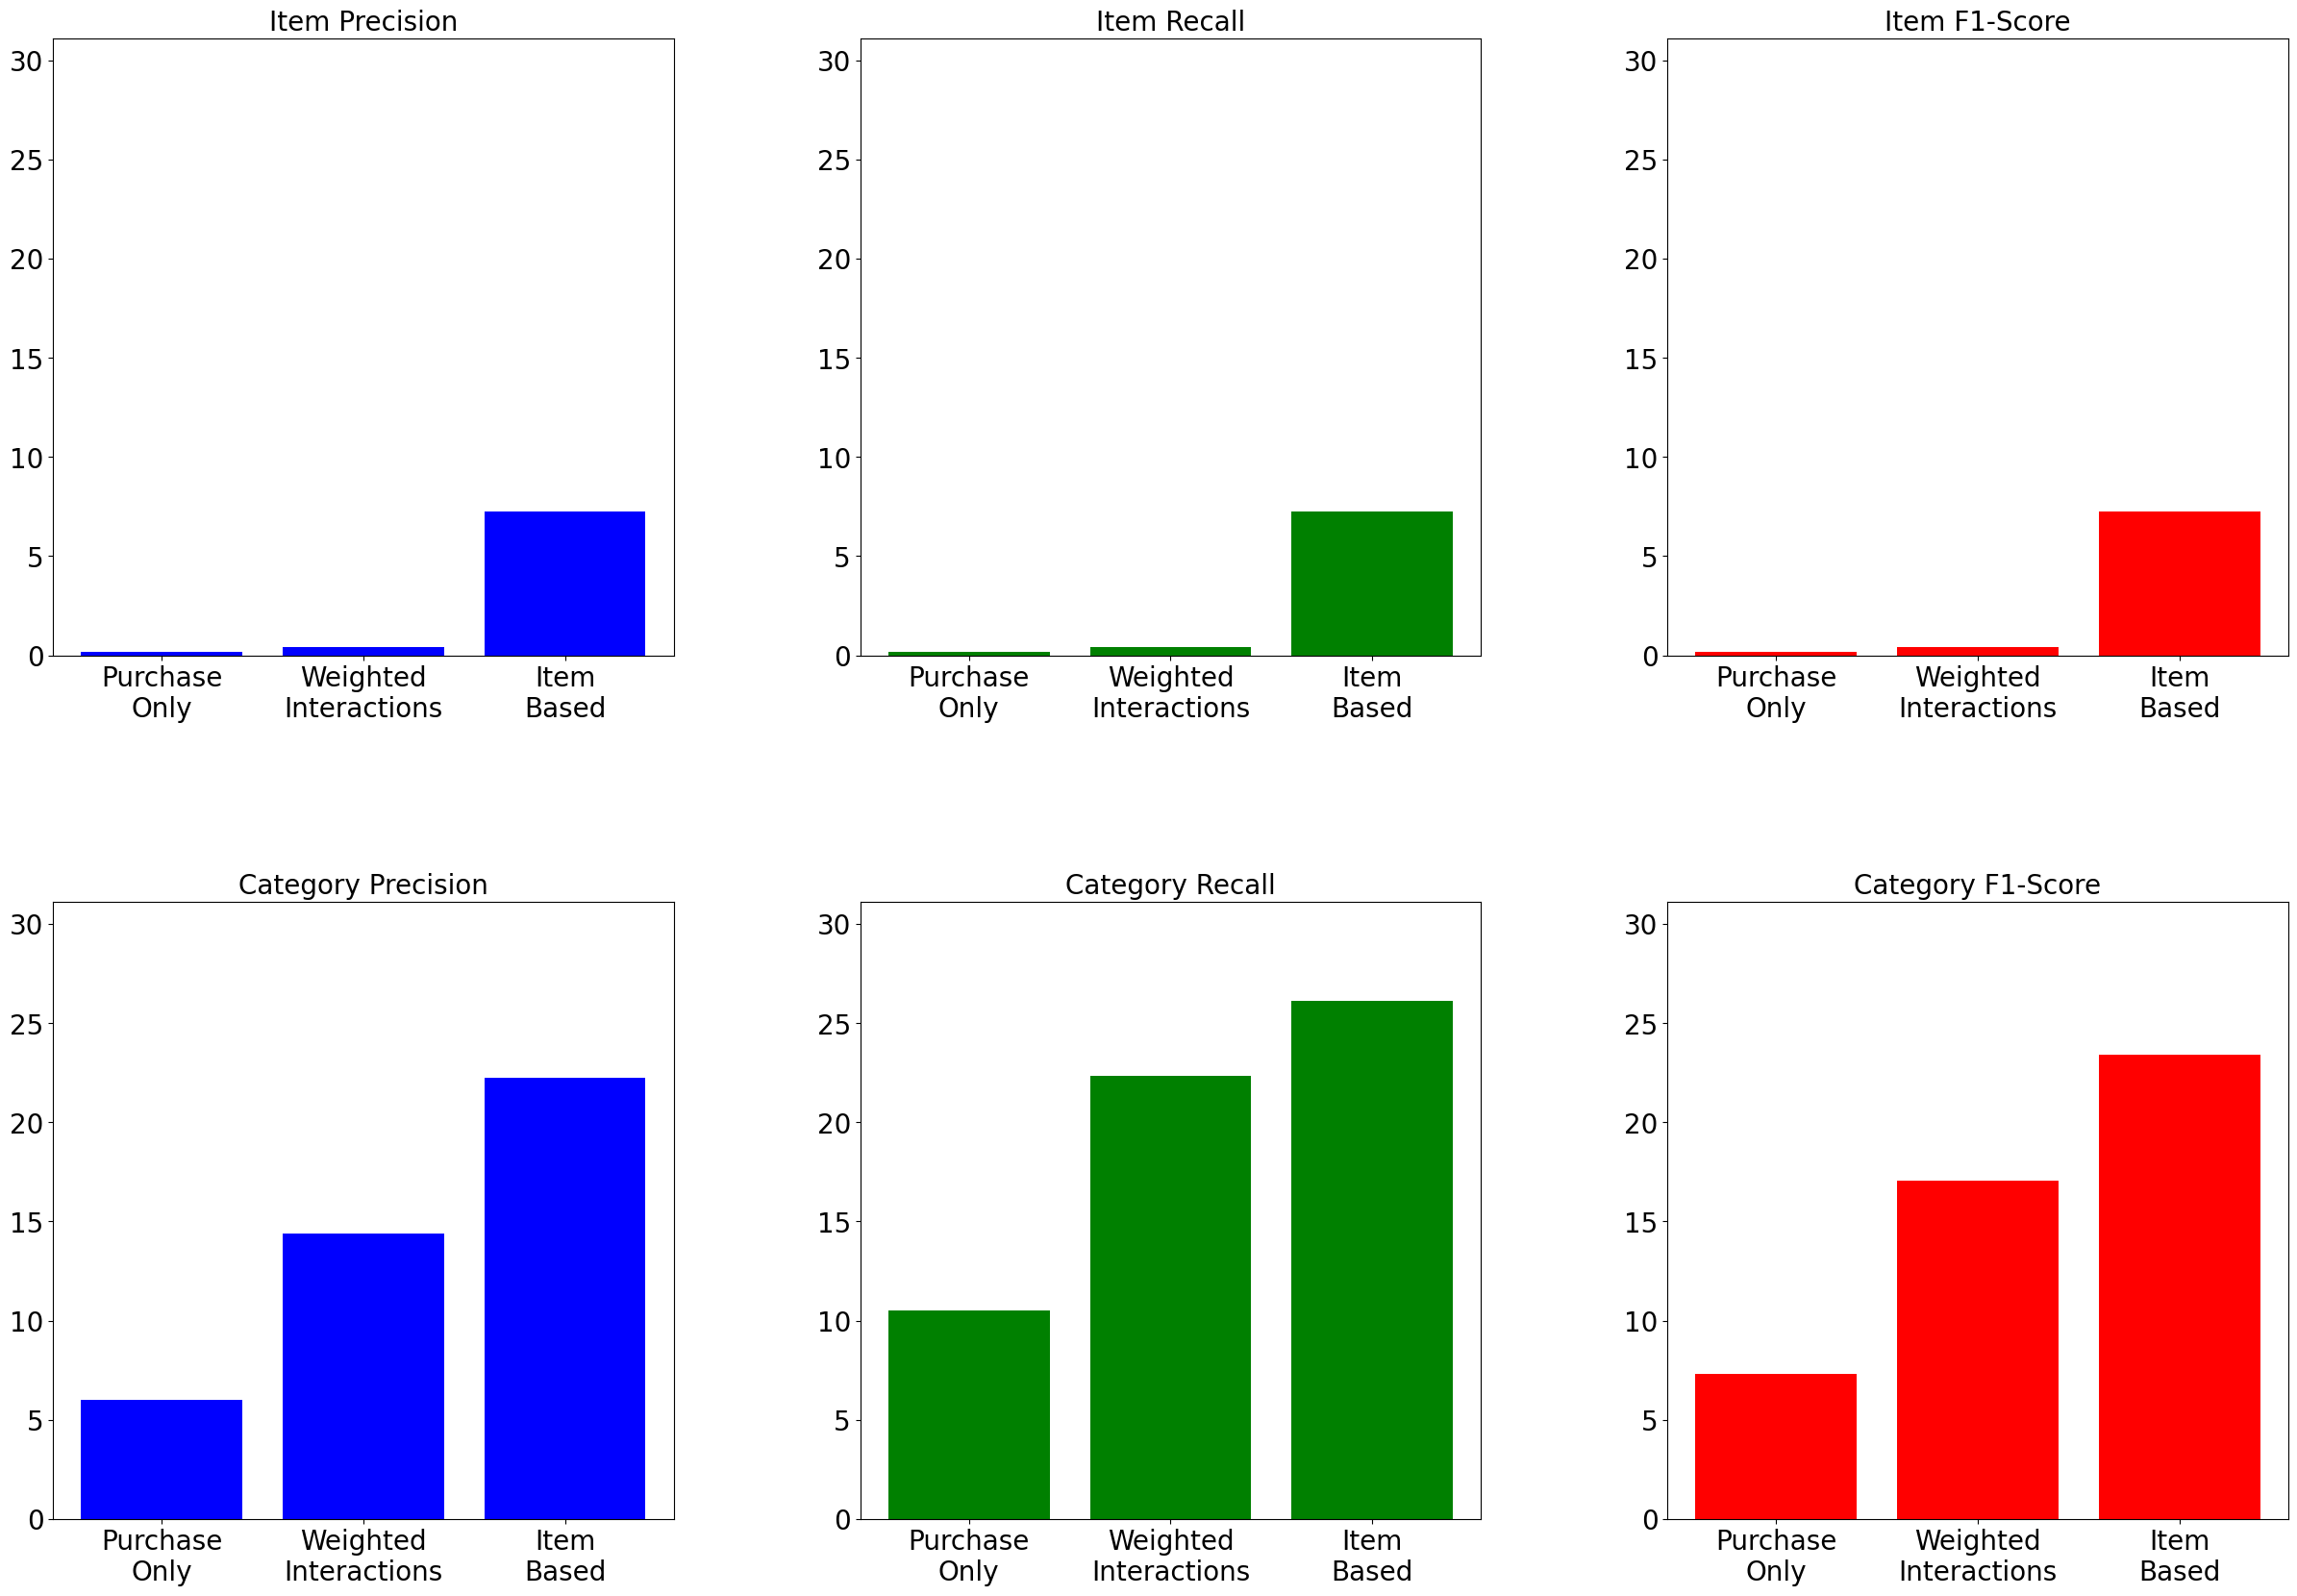

In [33]:
engines = ["Purchase\nOnly", "Weighted\nInteractions", "Item\nBased"]

# Item Stats
item_precision = [0.16, 0.42, 7.26]
item_recall = [0.16, 0.42, 7.26]
item_f1_score = [0.16, 0.42, 7.26]

# Category Stats
category_precision = [5.98, 14.39, 22.26]
category_recall = [10.52, 22.36, 26.10]
category_f1_score = [7.29, 17.04, 23.41]
# fig, axes = plt.subplots(2, 3, figsize=(25, 15))
fig, axes = plt.subplots(2, 3, figsize=(30, 20)) 
plt.subplots_adjust(hspace=0.4, wspace=0.3)

max_y_value = max(max(item_precision), max(item_recall), max(item_f1_score), 
                  max(category_precision), max(category_recall), max(category_f1_score)) + 5

# Item Stats
axes[0, 0].bar(engines, item_precision, color='blue')
axes[0, 0].set_title('Item Precision')
axes[0, 0].set_ylim(0, max_y_value)

axes[0, 1].bar(engines, item_recall, color='green')
axes[0, 1].set_title('Item Recall')
axes[0, 1].set_ylim(0, max_y_value)

axes[0, 2].bar(engines, item_f1_score, color='red')
axes[0, 2].set_title('Item F1-Score')
axes[0, 2].set_ylim(0, max_y_value)

# Category Stats
axes[1, 0].bar(engines, category_precision, color='blue')
axes[1, 0].set_title('Category Precision')
axes[1, 0].set_ylim(0, max_y_value)

axes[1, 1].bar(engines, category_recall, color='green')
axes[1, 1].set_title('Category Recall')
axes[1, 1].set_ylim(0, max_y_value)

axes[1, 2].bar(engines, category_f1_score, color='red')
axes[1, 2].set_title('Category F1-Score')
axes[1, 2].set_ylim(0, max_y_value)

# plt.tight_layout()
for ax in axes.flat:
    ax.title.set_size(20) # Increase title font size
    # ax.title.set_pad(20)  # Adjust the padding
    ax.tick_params(axis='both', which='major', labelsize=20)


plt.show()

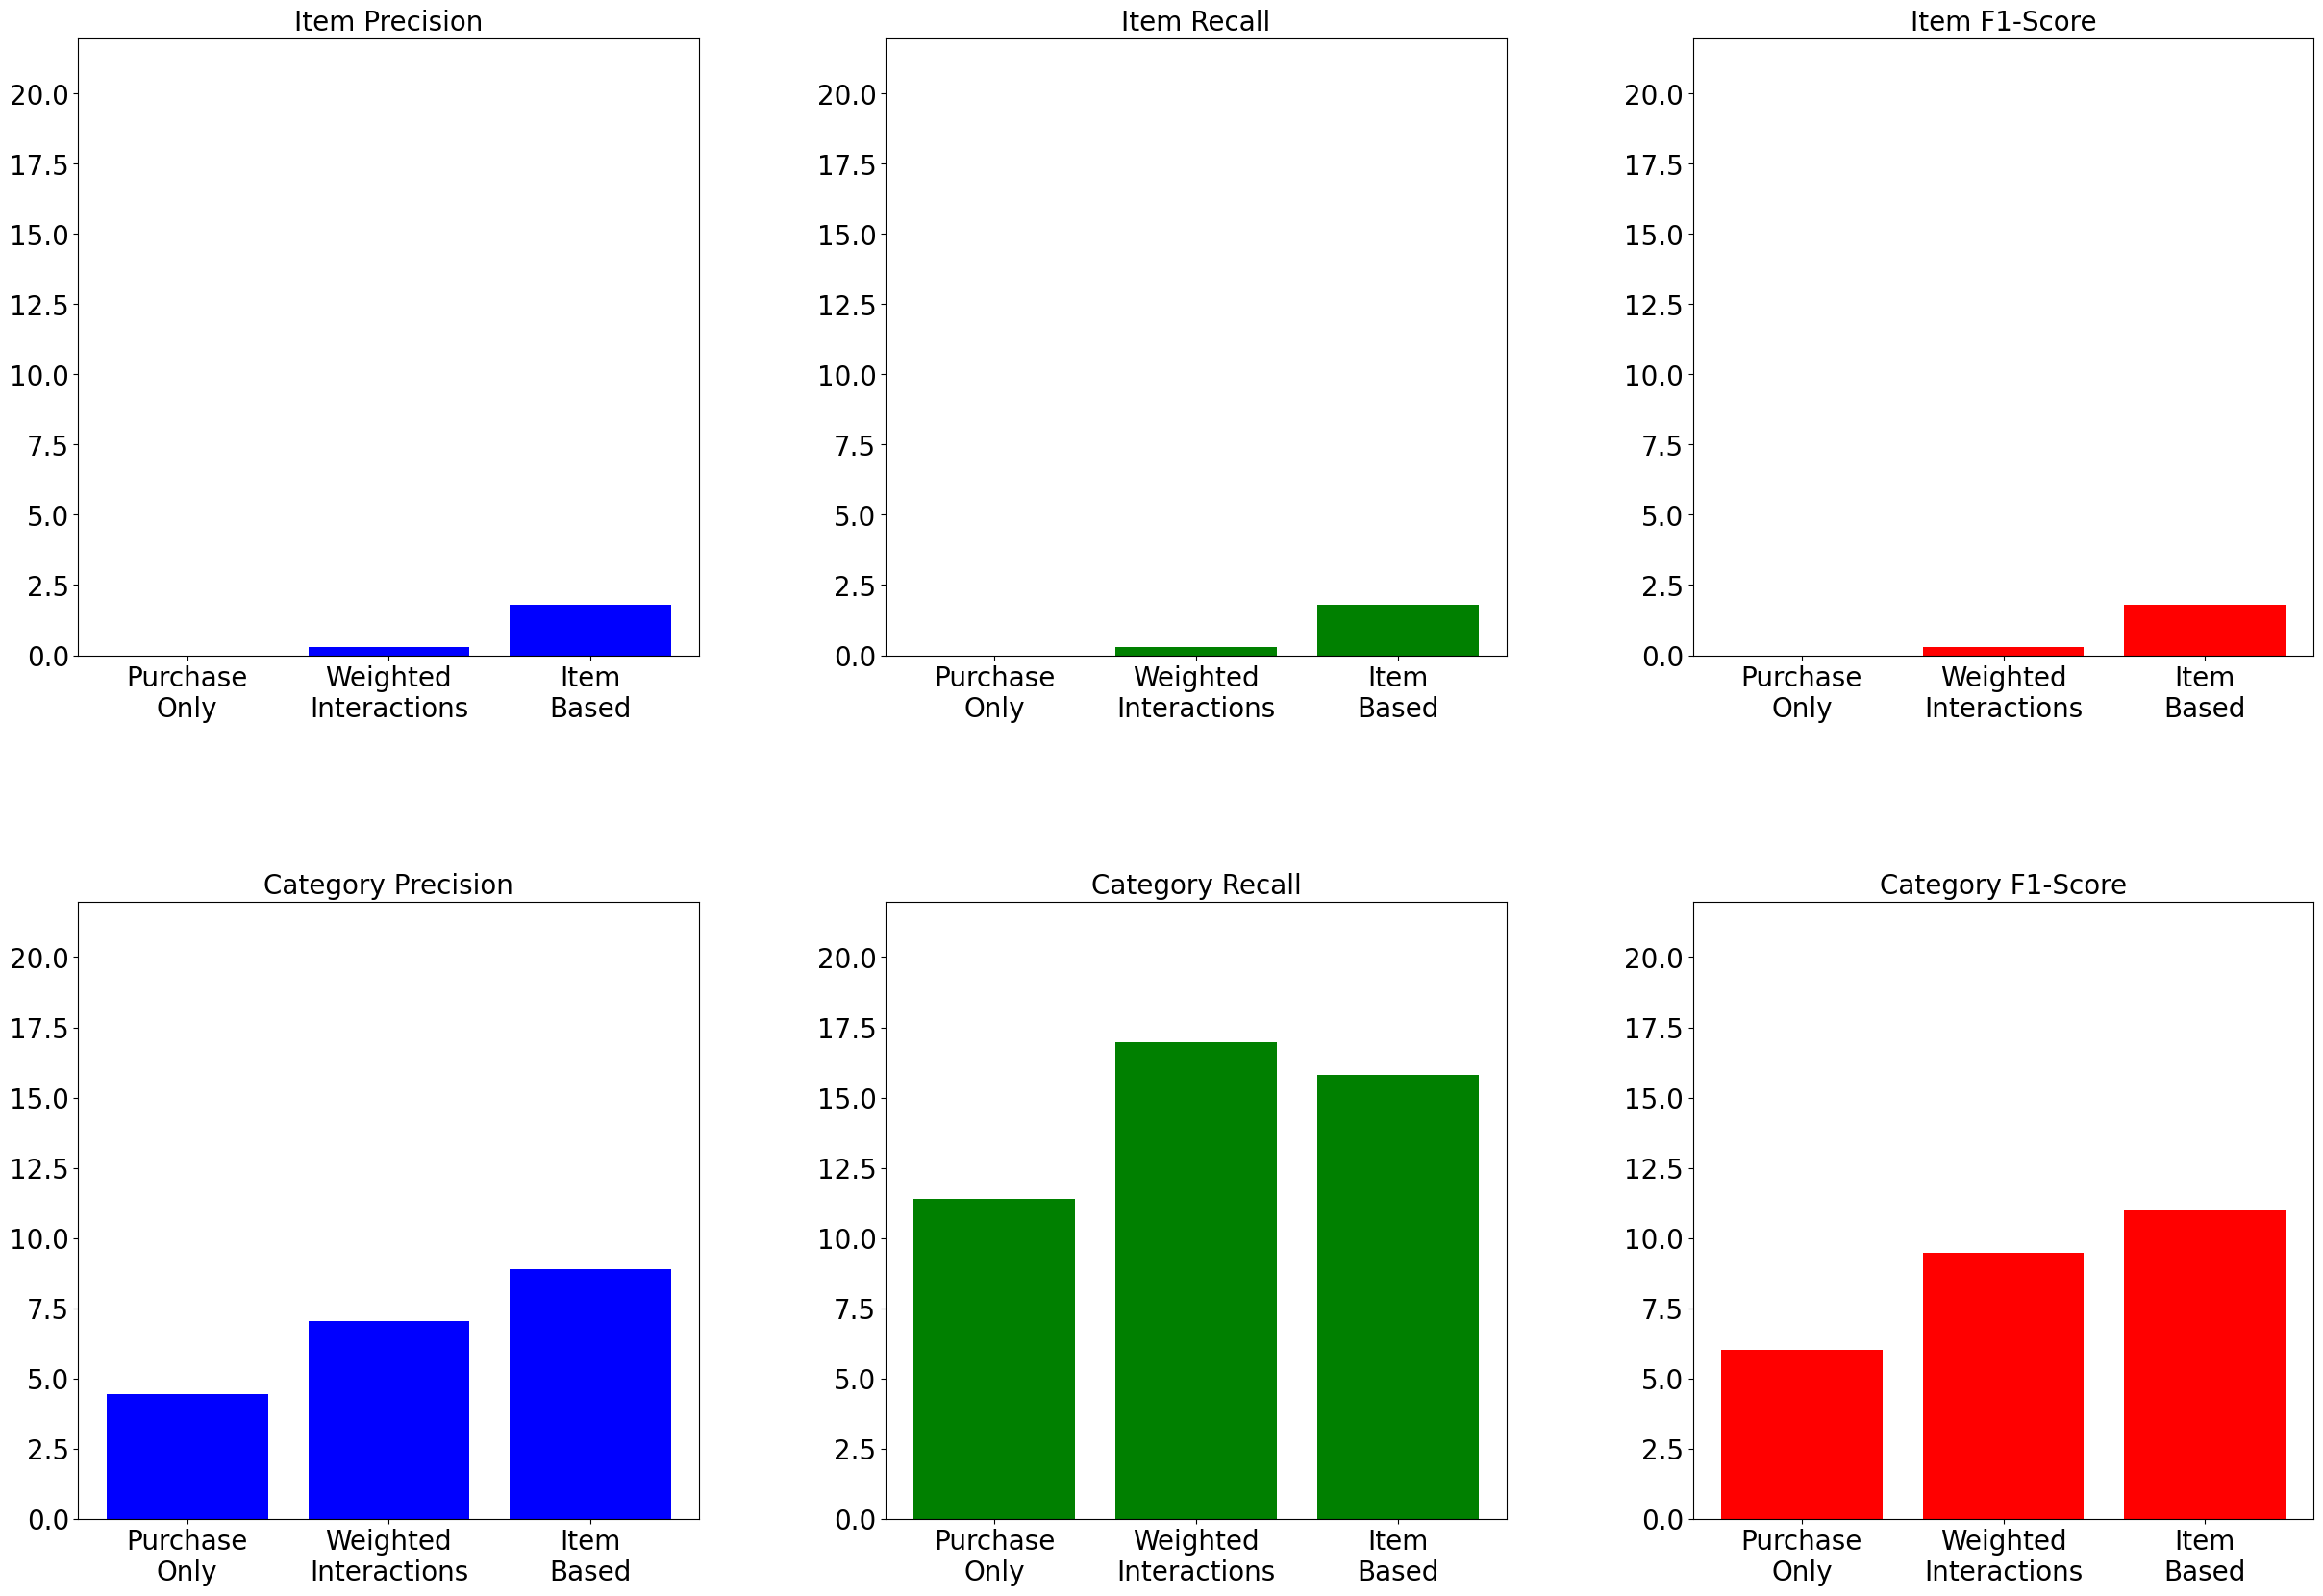

In [1]:
import matplotlib.pyplot as plt

engines = ["Purchase\nOnly", "Weighted\nInteractions", "Item\nBased"]

# Item Stats
item_precision = [0,0.3,1.79]
item_recall = [0,0.3,1.79]
item_f1_score = [0,0.3,1.79]

# Category Stats
category_precision = [4.44,7.06,8.91]
category_recall = [11.4,16.96,15.81]
category_f1_score = [6.02,9.49,10.98]
# fig, axes = plt.subplots(2, 3, figsize=(25, 15))
fig, axes = plt.subplots(2, 3, figsize=(30, 20)) 
plt.subplots_adjust(hspace=0.4, wspace=0.3)

max_y_value = max(max(item_precision), max(item_recall), max(item_f1_score), 
                  max(category_precision), max(category_recall), max(category_f1_score)) + 5

# Item Stats
axes[0, 0].bar(engines, item_precision, color='blue')
axes[0, 0].set_title('Item Precision')
axes[0, 0].set_ylim(0, max_y_value)

axes[0, 1].bar(engines, item_recall, color='green')
axes[0, 1].set_title('Item Recall')
axes[0, 1].set_ylim(0, max_y_value)

axes[0, 2].bar(engines, item_f1_score, color='red')
axes[0, 2].set_title('Item F1-Score')
axes[0, 2].set_ylim(0, max_y_value)

# Category Stats
axes[1, 0].bar(engines, category_precision, color='blue')
axes[1, 0].set_title('Category Precision')
axes[1, 0].set_ylim(0, max_y_value)

axes[1, 1].bar(engines, category_recall, color='green')
axes[1, 1].set_title('Category Recall')
axes[1, 1].set_ylim(0, max_y_value)

axes[1, 2].bar(engines, category_f1_score, color='red')
axes[1, 2].set_title('Category F1-Score')
axes[1, 2].set_ylim(0, max_y_value)

# plt.tight_layout()
for ax in axes.flat:
    ax.title.set_size(20) # Increase title font size
    # ax.title.set_pad(20)  # Adjust the padding
    ax.tick_params(axis='both', which='major', labelsize=20)


plt.show()